## Customer Default Payments - Decision Trees and Ensemble Models

## Project Overview

We will use Classification Trees for predicting if a user has a default payment option active or not. The data is public and can be found using this link:
https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

This dataset is aimed at the case of customer default payments in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default.

Then we will use decision trees to make predictions, and RandomGrid for hyper-parameters tuning for decision trees. We will also explore the effectiveness of ensemble algorithms (Random Forest, Adaboost, Extra trees classifier, Gradient Boosted Tree).

In [1]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
# extra step to allow graphviz to be found 
import os
os.environ["PATH"] += os.pathsep + "C:\\Users\\Ivian\\anaconda3\\Library\\bin\\graphviz"

In [4]:
#required imports
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
import graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, precision_score, recall_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

After installing the necessary libraries, proceed to download the data. Since reading the excel file won't create headers by default, we added two more operations to substitute the columns.

In [5]:
#loading the data
dataset = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls")
dataset.columns = dataset.iloc[0]
dataset = dataset[1:]
dataset.drop(['ID'], axis=1, inplace=True)

In [6]:
dataset.head(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In the following, you can take a look into the dataset.

In [7]:
dataset.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
10,20000,1,3,2,35,-2,-2,-2,-2,-1,...,0,13007,13912,0,0,0,13007,1122,0,0


In [8]:
#Checking if there are any null values
dataset.isnull().values.any()

False

In [9]:
#Confirming all the data types
np.unique(dataset.dtypes)

array([dtype('O')], dtype=object)

In [10]:
dataset = dataset.astype('int')

In [11]:
#Confirming all the data types
np.unique(dataset.dtypes)

array([dtype('int32')], dtype=object)

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int32
 1   SEX                         30000 non-null  int32
 2   EDUCATION                   30000 non-null  int32
 3   MARRIAGE                    30000 non-null  int32
 4   AGE                         30000 non-null  int32
 5   PAY_0                       30000 non-null  int32
 6   PAY_2                       30000 non-null  int32
 7   PAY_3                       30000 non-null  int32
 8   PAY_4                       30000 non-null  int32
 9   PAY_5                       30000 non-null  int32
 10  PAY_6                       30000 non-null  int32
 11  BILL_AMT1                   30000 non-null  int32
 12  BILL_AMT2                   30000 non-null  int32
 13  BILL_AMT3                   30000 non-null  int32
 14  BILL_A

## Model
We will build a classifier by using decision tree and calculate the confusion matrix.

In [13]:
X=dataset[dataset.columns[:-1]]
y=dataset['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [14]:
np.unique(y_train.dtypes)

array([dtype('int32')], dtype=object)

In [15]:
#Using the decision tree classifier
tree_entropy = DecisionTreeClassifier(max_depth=5, criterion='entropy')

# Train the estimator.
tree_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

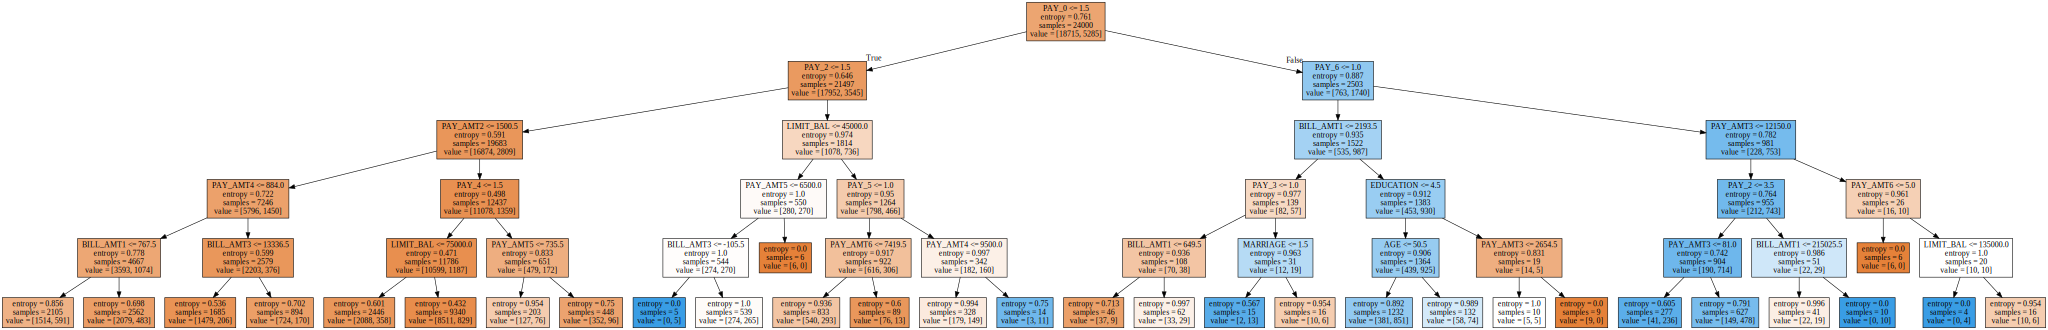

In [16]:
#Plotting the decision tree
graph = Source(tree.export_graphviz(tree_entropy, out_file=None,feature_names=X.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

In [17]:
# Finding the feature importance 
zip(X.columns, tree_entropy.feature_importances_)

In [18]:
# Calculating predictions
tr_ent_pred=tree_entropy.predict(X_test)

# Accuracy
print('Accuracy: %.3f' % tree_entropy.score(X_test, y_test))

# Precision
print('Precision: %.3f' % precision_score(y_test, tr_ent_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, tr_ent_pred))

# f1 score
print('F1 score: %.3f' % f1_score(y_test, tr_ent_pred))

Accuracy: 0.816
Precision: 0.717
Recall: 0.305
F1 score: 0.428


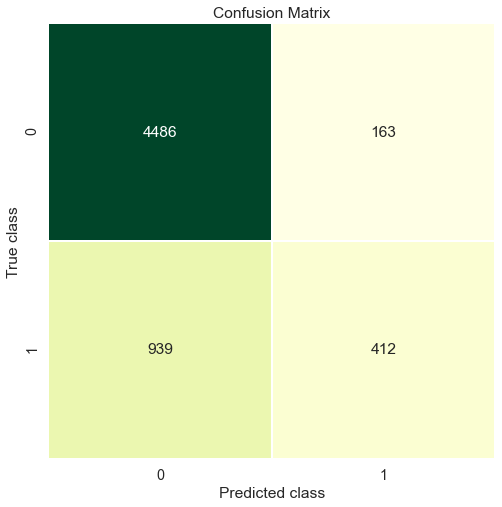

In [19]:
# Plotting confusion matrix
tr_ent_matrix = confusion_matrix(y_test,tr_ent_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(tr_ent_matrix,annot=True, cbar=False, cmap='YlGn',linewidth=0.5,fmt="d")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Confusion Matrix');

In [20]:
# Predict propabilities
tr_ent_probs = tree_entropy.predict_proba(X_test)

# Positive class only.
tr_ent_probs = tr_ent_probs[:, 1]

# Calculating the AUC Score
auc_tr_ent = roc_auc_score(y_test, tr_ent_probs)
print('AUC: %.3f' % auc_tr_ent)

AUC: 0.762


In [21]:
results_tree = pd.DataFrame([['Decision Tree Entropy', tree_entropy.score(X_test, y_test),
                              precision_score(y_test, tr_ent_pred),recall_score(y_test, tr_ent_pred), 
                              f1_score(y_test, tr_ent_pred),roc_auc_score(y_test, tr_ent_probs)]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC'])
results_tree

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Decision Tree Entropy,0.816333,0.716522,0.304959,0.42783,0.762174


In [22]:
tree_gini = DecisionTreeClassifier(max_depth=5, criterion='gini')

# Train the estimator.
tree_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

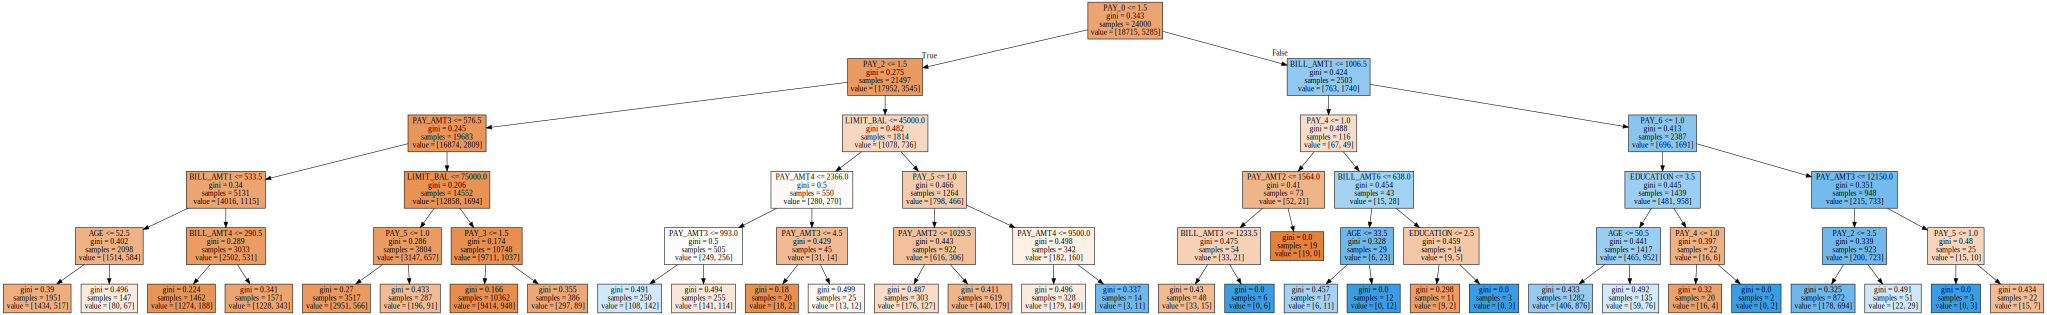

In [23]:
graph = Source(tree.export_graphviz(tree_gini, out_file=None,feature_names=X.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

In [24]:
# Make predictions
tr_pred2=tree_gini.predict(X_test)

# Accuracy
print('Accuracy: %.3f' % tree_gini.score(X_test, y_test))

# Precision
print('Precision: %.3f' % precision_score(y_test, tr_pred2))

# Recall
print('Recall: %.3f' % recall_score(y_test, tr_pred2))

# f1 score
print('F1 score: %.3f' % f1_score(y_test, tr_pred2))

Accuracy: 0.814
Precision: 0.677
Recall: 0.329
F1 score: 0.442


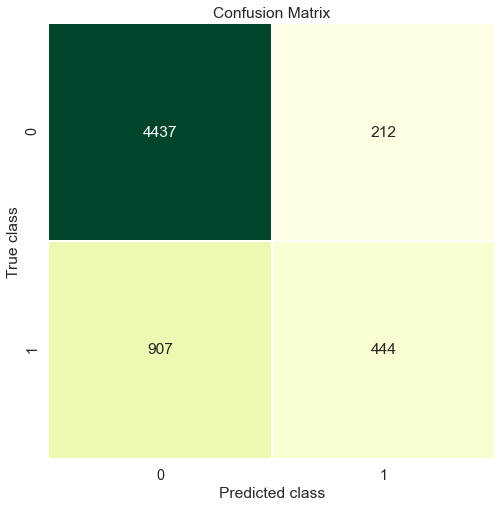

In [25]:
# Plotting confusion matrix
tr_matrix2 = confusion_matrix(y_test,tr_pred2)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(tr_matrix2,annot=True, cbar=False, cmap='YlGn',linewidth=0.5,fmt="d")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Confusion Matrix');

In [26]:
# Predict propabilities
tr_probs2 = tree_gini.predict_proba(X_test)

# Positive class only.
tr_probs2 = tr_probs2[:, 1]

# Ccalculating the AUC Score
auc_tr2 = roc_auc_score(y_test, tr_probs2)
print('AUC: %.2f' % auc_tr2)

AUC: 0.76


In [27]:
results_tree2 = pd.DataFrame([['Decision Tree Gini', tree_gini.score(X_test, y_test),
                              precision_score(y_test, tr_pred2),recall_score(y_test, tr_pred2), 
                              f1_score(y_test, tr_pred2),roc_auc_score(y_test, tr_probs2)]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC'])
results_tree = results_tree.append(results_tree2, ignore_index = True)
results_tree

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Decision Tree Entropy,0.816333,0.716522,0.304959,0.427830,0.762174
1,Decision Tree Gini,0.813500,0.676829,0.328645,0.442451,0.760101


In [28]:
parameters = {'criterion':['gini','entropy'],
              'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
             }

# GridSearchCV estimator
gs_tree = GridSearchCV(tree_entropy, parameters, cv=10, n_jobs=-1,verbose=1)

# Search for the best parameters.
gs_tree.fit(X_train,y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]},
             verbose=1)

In [29]:
# Using the best parameters for predictions
gs_tree_pred=gs_tree.predict(X_test)

In [30]:
# Best parameters.
print("Best Decision tree Parameters: {}".format(gs_tree.best_params_))

# Cross validation accuracy
print('Cross-validation accuracy: %0.3f' % gs_tree.best_score_)

# Accuracy
print('Accuracy: %0.3f' % (gs_tree.score(X_test,y_test)))

# Precision
print('Precision: %.3f' % precision_score(y_test, gs_tree_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, gs_tree_pred))

# f1 score
print('F1 score: %.3f' % f1_score(y_test, gs_tree_pred))

Best Decision tree Parameters: {'criterion': 'gini', 'max_depth': 2}
Cross-validation accuracy: 0.821
Accuracy: 0.816
Precision: 0.705
Recall: 0.312
F1 score: 0.433


In [31]:
# Predict probabilities
gs_tree_probs = gs_tree.predict_proba(X_test)

# KPositive class only
gs_tree_probs = gs_tree_probs[:, 1]

# Calculating the AUC Score
gs_tree_auc = roc_auc_score(y_test, gs_tree_probs)
print('AUC: %.2f' % gs_tree_auc)

AUC: 0.70


In [32]:
results_tree3 = pd.DataFrame([['Decision Tree GridSearch', gs_tree.score(X_test, y_test),
                              precision_score(y_test, gs_tree_pred),recall_score(y_test, gs_tree_pred), 
                              f1_score(y_test, gs_tree_pred),roc_auc_score(y_test, gs_tree_pred)]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC'])
results_tree = results_tree.append(results_tree3, ignore_index = True)
results_tree

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Decision Tree Entropy,0.816333,0.716522,0.304959,0.427830,0.762174
1,Decision Tree Gini,0.813500,0.676829,0.328645,0.442451,0.760101
2,Decision Tree GridSearch,0.815667,0.704508,0.312361,0.432821,0.637144


- We tried different hyperparameters: entropy, gini using max depth as 5. Then using grid search we found the best decision tree Parameters: {'criterion': 'gini', 'max_depth': 2}.
- The decision tree using entropy and gini with the same max depth the results were very similar. Entropy performed slightly better in terms of accuracy and AUC.
- Using grid search, the accuracy was similar as well, slight better than gini, and entropy was slight better than grid search in terms of accuracy. But the AUC score dropped significantly when compared to entropy and gini with max depth as 5.

We will build the decision again, but this time by RandomizedSearchCV over hyper-parameters.

In [33]:
#Parameters list
param_rs = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [34]:
random_search_cv = RandomizedSearchCV(tree_entropy, param_rs, cv=5)

In [35]:
random_search_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=5),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AAFB560160>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AAFB560400>})

In [36]:
# Prediction with best parameters
random_search_cv_pred=random_search_cv.predict(X_test)

In [37]:
# Best parameters
print("Best Decision tree Parameters: {}".format(random_search_cv.best_params_))

# Cross validation
print('Cross-validation accuracy: %0.3f' % random_search_cv.best_score_)

# Accuracy
print('Accuracy: %0.3f' % (random_search_cv.score(X_test,y_test)))

# Precision
print('Precision: %.3f' % precision_score(y_test, random_search_cv_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, random_search_cv_pred))

# f1 score
print('F1 score: %.3f' % f1_score(y_test, random_search_cv_pred))

Best Decision tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 2}
Cross-validation accuracy: 0.816
Accuracy: 0.816
Precision: 0.697
Recall: 0.323
F1 score: 0.442


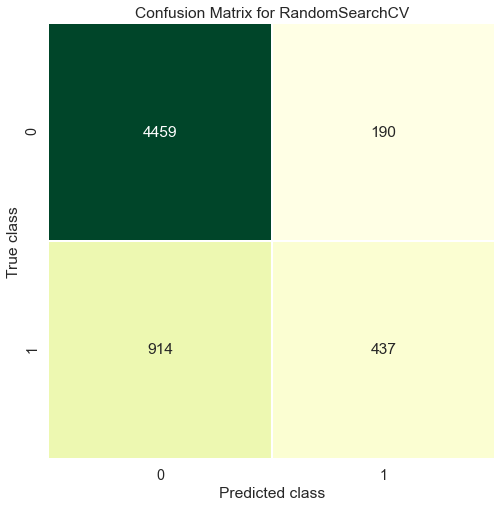

In [38]:
# Plotting confusion matrix
random_tr_matrix = confusion_matrix(y_test,random_search_cv_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(random_tr_matrix,annot=True, cbar=False, cmap='YlGn',linewidth=0.5,fmt="d")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Confusion Matrix for RandomSearchCV');

In [39]:
# Predict probabilities
random_search_cv_probs = random_search_cv.predict_proba(X_test)

# Positive class only.
random_search_cv_probs = random_search_cv_probs[:, 1]

# Calculating the AUC Score
random_search_cv_auc = roc_auc_score(y_test, random_search_cv_probs)
print('AUC: %.2f' % random_search_cv_auc)

AUC: 0.73


In [40]:
# Comparing hyper parameters
results_tree4 = pd.DataFrame([['Decision Tree RandomSearch', random_search_cv.score(X_test, y_test),
                              precision_score(y_test, random_search_cv_pred),recall_score(y_test, random_search_cv_pred), 
                              f1_score(y_test, random_search_cv_pred),roc_auc_score(y_test, random_search_cv_probs)]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC'])
results_tree = results_tree.append(results_tree4, ignore_index = True)
results_tree

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Decision Tree Entropy,0.816333,0.716522,0.304959,0.427830,0.762174
1,Decision Tree Gini,0.813500,0.676829,0.328645,0.442451,0.760101
2,Decision Tree GridSearch,0.815667,0.704508,0.312361,0.432821,0.637144
3,Decision Tree RandomSearch,0.816000,0.696970,0.323464,0.441860,0.727931


- Using the random search, we got as best decision tree parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 5}
- Comparing with the previous question results, we can see that the accuracy did not improve when compared to entropy, gini and grid search. In terms of AUC score, it improved when compred to grid search, but it was still lower than entropy and gini. Overall, the decision tree entropy still performed better.

### Ensemble Models

We will build the same classifier by using the following ensemble models.

* Random Forest 
* AdaBoost
* Extra Trees Classifier 
* Gradient Boosted Trees 


In [41]:
# YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from time import time

In [42]:
#Random Forest
rndm_forest = RandomForestClassifier(n_estimators=50, max_leaf_nodes=16, n_jobs=-1)
start = time()
rndm_forest.fit(X_train, y_train)
end=time()
train_time_rndm_forest=end-start

In [43]:
# Probabilities
rndm_forest_probs = rndm_forest.predict_proba(X_test)

# Positive class only.
rndm_forest_probs = rndm_forest_probs[:, 1]

# Calculating the AUC Score
rndm_forest_auc = roc_auc_score(y_test, rndm_forest_probs)
print('AUC: %.2f' % rndm_forest_auc)

AUC: 0.78


In [44]:
y_pred_mod1 = rndm_forest.predict(X_test)
results_model = pd.DataFrame([['Random Forest', accuracy_score(y_test, y_pred_mod1),
                              precision_score(y_test, y_pred_mod1),recall_score(y_test, y_pred_mod1), 
                              f1_score(y_test, y_pred_mod1),roc_auc_score(y_test, y_pred_mod1)]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC'])
#results_model = results_model.append(results_model2, ignore_index = True)
results_model

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.8115,0.712355,0.273131,0.394864,0.620541


In [45]:
#Ada Boost
ada_boost = AdaBoostClassifier(tree_entropy, n_estimators=50, algorithm="SAMME.R", learning_rate=0.5)
start = time()
ada_boost.fit(X_train, y_train)
end = time()
train_time_ada=end-start

In [46]:
# Probabilities
ada_boost_probs = ada_boost.predict_proba(X_test)

# Positive class only
ada_boost_probs = ada_boost_probs[:, 1]

# Calculating the AUC Score
ada_boost_auc = roc_auc_score(y_test, ada_boost_probs)
print('AUC: %.2f' % ada_boost_auc)

AUC: 0.74


In [47]:
y_pred_mod2 = ada_boost.predict(X_test)
results_model2 = pd.DataFrame([['Ada Boost', accuracy_score(y_test, y_pred_mod2),
                              precision_score(y_test, y_pred_mod2),recall_score(y_test, y_pred_mod2), 
                              f1_score(y_test, y_pred_mod2),roc_auc_score(y_test, y_pred_mod2)]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC'])
results_model = results_model.append(results_model2, ignore_index = True)
results_model

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.811500,0.712355,0.273131,0.394864,0.620541
1,Ada Boost,0.810167,0.635550,0.367876,0.466010,0.653286


In [48]:
#Extra trees classifier
extra_trees = ExtraTreesClassifier(n_estimators=50)
start = time()
extra_trees.fit(X_train, y_train)
end = time()
train_time_extra_tree=end-start

In [49]:
# Probabilities
extra_tree_probs = extra_trees.predict_proba(X_test)

# Positive class only
extra_tree_probs = extra_tree_probs[:, 1]

# Calculating the AUC Score
extra_tree_auc = roc_auc_score(y_test, extra_tree_probs)
print('AUC: %.2f' % extra_tree_auc)

AUC: 0.76


In [50]:
y_pred_mod3 = extra_trees.predict(X_test)
results_model3 = pd.DataFrame([['Extra trees', accuracy_score(y_test, y_pred_mod3),
                              precision_score(y_test, y_pred_mod3),recall_score(y_test, y_pred_mod3), 
                              f1_score(y_test, y_pred_mod3),roc_auc_score(y_test, y_pred_mod3)]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC'])
results_model = results_model.append(results_model3, ignore_index = True)
results_model

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.811500,0.712355,0.273131,0.394864,0.620541
1,Ada Boost,0.810167,0.635550,0.367876,0.466010,0.653286
2,Extra trees,0.809833,0.640374,0.354552,0.456408,0.648345


In [51]:
#Gradient Boosted Trees

gradientb = GradientBoostingClassifier(n_estimators=50)
start = time()
gradientb.fit(X_train, y_train)
end=time()
train_time_gradient=end-start

In [52]:
# Predict probabilities for the test data.
gradient_probs = gradientb.predict_proba(X_test)

# Keep Probabilities of the positive class only.
gradient_probs = gradient_probs[:, 1]

# Compute the AUC Score.
gradient_auc = roc_auc_score(y_test, gradient_probs)
print('AUC: %.2f' % gradient_auc)

AUC: 0.79


In [53]:
y_pred_mod4 = gradientb.predict(X_test)
results_model4 = pd.DataFrame([['Gradient Boosted Trees', accuracy_score(y_test, y_pred_mod4),
                              precision_score(y_test, y_pred_mod4),recall_score(y_test, y_pred_mod4), 
                              f1_score(y_test, y_pred_mod4),roc_auc_score(y_test, y_pred_mod4)]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC'])
results_model = results_model.append(results_model4, ignore_index = True)
results_model

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.811500,0.712355,0.273131,0.394864,0.620541
1,Ada Boost,0.810167,0.635550,0.367876,0.466010,0.653286
2,Extra trees,0.809833,0.640374,0.354552,0.456408,0.648345
3,Gradient Boosted Trees,0.820167,0.699413,0.353072,0.469257,0.654488


In [54]:
print('Random Forest training time: %.2f' % train_time_rndm_forest)
print('Ada Boost training time: %.2f' % train_time_ada)
print('Extra trees training time: %.2f' % train_time_extra_tree)
print('Gradient Boosted training time: %.2f' % train_time_gradient)

Random Forest training time: 0.61
Ada Boost training time: 15.96
Extra trees training time: 2.11
Gradient Boosted training time: 6.15


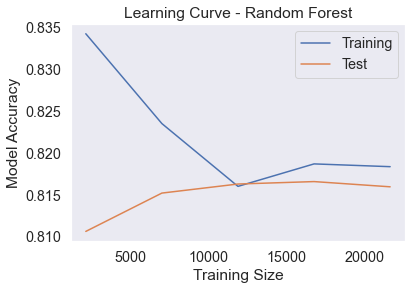

In [55]:
from sklearn.model_selection import learning_curve
train_size, train_score, test_score = learning_curve(estimator=rndm_forest, X=X_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 5),
                                                     n_jobs=1)
#Mean for train and test set
train_mean = np.mean(train_score, axis=1)
test_mean = np.mean(test_score, axis=1)

#Plotting the learning curve
plt.plot(train_size, train_mean, label='Training')
plt.plot(train_size, test_mean, label='Test')
plt.title('Learning Curve - Random Forest')
plt.xlabel('Training Size')
plt.ylabel('Model Accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

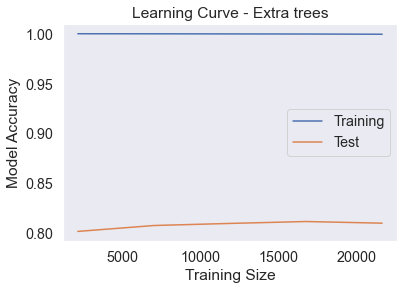

In [56]:
from sklearn.model_selection import learning_curve
train_size, train_score, test_score = learning_curve(estimator=extra_trees, X=X_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 5),
                                                     n_jobs=1)
#Mean for train and test set
train_mean = np.mean(train_score, axis=1)
test_mean = np.mean(test_score, axis=1)

#Plotting the learning curve
plt.plot(train_size, train_mean, label='Training')
plt.plot(train_size, test_mean, label='Test')
plt.title('Learning Curve - Extra trees')
plt.xlabel('Training Size')
plt.ylabel('Model Accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

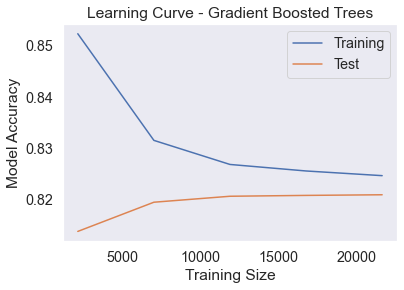

In [57]:
train_size, train_score, test_score = learning_curve(estimator=gradientb, X=X_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 5),
                                                     n_jobs=1)
#Mean for train and test set
train_mean = np.mean(train_score, axis=1)
test_mean = np.mean(test_score, axis=1)

#Plotting the learning curve
plt.plot(train_size, train_mean, label='Training')
plt.plot(train_size, test_mean, label='Test')
plt.title('Learning Curve - Gradient Boosted Trees')
plt.xlabel('Training Size')
plt.ylabel('Model Accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

- Comparing all four models, we were able to get better overall results with the Grandient Boosted Trees. The results between the models were fairly similar, but the random forest was the fastest.

### Summary

- Summarizing the hyperparameters analysis, we saw that:
    - We tried different hyperparameters: entropy, gini using max depth as 5. Then using grid search we found the best decision tree Parameters: {'criterion': 'gini', 'max_depth': 2}.
    - The decision tree using entropy and gini with the same max depth the results were very similar. Entropy performed slightly better in terms of accuracy and AUC.
    - Using grid search, the accuracy was similar as well, slight better than gini, and entropy was slight better than grid search in terms of accuracy. But the AUC score dropped significantly when compared to entropy and gini with max depth as 5.
    - Using the random search, we got as best decision tree parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 5}
    - Comparing with the first question results, we can see that the accuracy did not improve when compared to entropy, gini and grid search. In terms of AUC score, it improved when compred to grid search, but it was still lower than entropy and gini. Overall, the decision tree entropy still performed better.
    - In terms of different ensemble models and comparing all four models, we were able to get better overall results with the Grandient Boosted Trees. The results between the models were fairly similar, but the random forest was the fastest.

- In terms of models, we can see that certain models perform better or worse than others due to the differences in learning and model goals. For example, we have sequential ensemble models (Ada Boost is one example) that generates base learners sequentially and explores the dependence between the learners. As for parallel ensemble models (Random Forest is one example), the base learners are generated in parallel and explore the independence rather than the dependence of the learners.
- Another point is the use of aggregation or boosting techniques. Aggregation or bagging create several subsets of data from the training set and chose them randomly and this trains the decision trees. Boosting creates a collection of predictores and the learners are applied sequentially (fitting consecutive trees at every step).
- This aligns with the results and strengths/weakness of the models, since the ensemble models improve the accuracy of the results. The boosted models also have better AUC score, while random forest and extra trees have lower AUC score. Considering the way the ensemble models proceed with the learning, it also explains that the extra trees and random forest are faster and the boosted models take more time for learning.
